In [12]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import pickle


# Load the dataloaders
train_dataloader = pickle.load(open(os.path.join(os.getcwd(), '..', "data", "pytorch_data", 'train_dataloader.pkl'), 'rb'))
val_dataloader = pickle.load(open(os.path.join(os.getcwd(), '..', "data", "pytorch_data", 'val_dataloader.pkl'), 'rb'))
test_dataloader = pickle.load(open(os.path.join(os.getcwd(), '..', "data", "pytorch_data", 'test_dataloader.pkl'), 'rb'))

for team_input, player_input, ball_input, labels, mask in train_dataloader:
    print(f"Team input shape: {team_input.shape}")  # [batch_size, team_feature_dim]
    print(f"Player input shape: {player_input.shape}")  # [batch_size, player_feature_dim]
    print(f"Padded ball input shape: {ball_input.shape}")  # [batch_size, max_seq_len, ball_feature_dim]
    print(f"Mask shape: {mask.shape}")  # [batch_size, max_seq_len]
    print(f"Labels shape: {labels.shape}")  # [batch_size]
    break

Team input shape: torch.Size([32, 13])
Player input shape: torch.Size([32, 22, 11])
Padded ball input shape: torch.Size([32, 259, 10])
Mask shape: torch.Size([32, 259])
Labels shape: torch.Size([32])


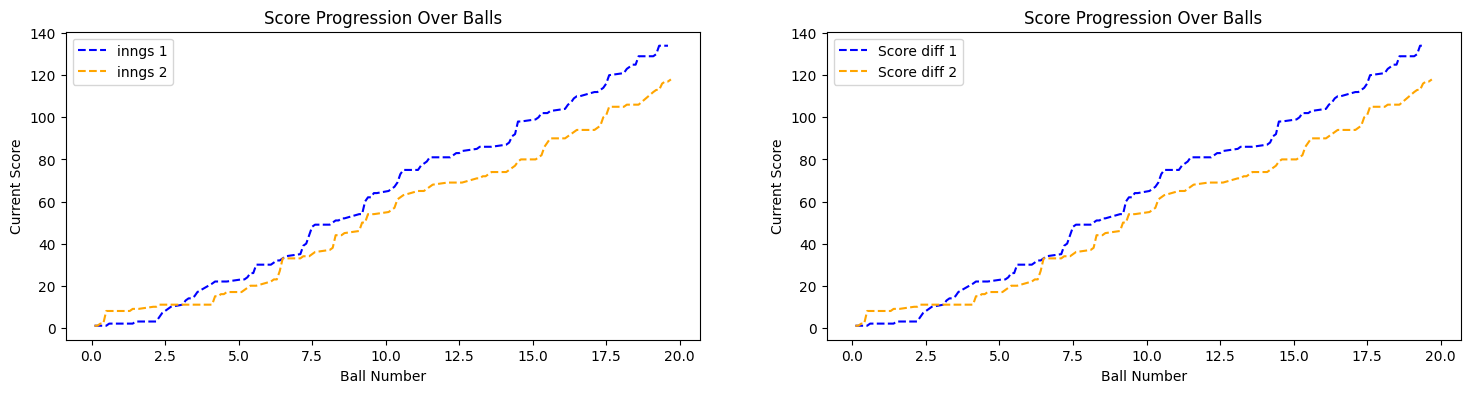

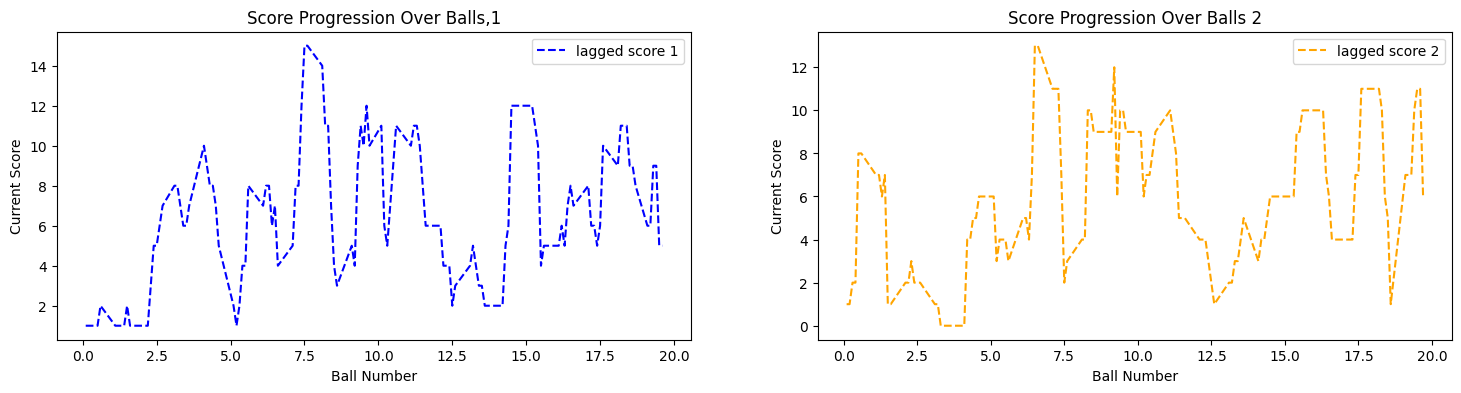

1.0
Sample 28


In [36]:
import matplotlib.pyplot as plt
import polars as pl
import numpy as np

i= np.random.randint(0, len(labels))
data = pl.DataFrame(ball_input[i].numpy(),schema=["innings","ball","runs","wickets","curr_score","curr_wickets","overs","run_rate","required_run_rate","target"])
label = labels[i].numpy()
innings1 = data.filter(data['innings'] == 1)
innings2 = data.filter(data['innings'] == 2)

# Visualize the progression of score over balls
fig,[ax1,ax2] = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
ax1.plot(innings1.to_pandas()["ball"], innings1.to_pandas()["curr_score"], linestyle="--", color="blue", label="inngs 1")
ax1.plot(innings2.to_pandas()["ball"], innings2.to_pandas()["curr_score"], linestyle="--", color="orange", label="inngs 2")

ax1.set_title("Score Progression Over Balls")
ax1.set_xlabel("Ball Number")
ax1.set_ylabel("Current Score")
ax1.legend()

# Ensure the lengths of diff1 and diff2 are the same
diff1 = innings1.to_pandas()["curr_score"].values[:min(len(innings1), len(innings2))]
diff2 = innings2.to_pandas()["curr_score"].values[:min(len(innings1), len(innings2))]
min_length = min(len(diff1), len(diff2))
ax2.plot(innings1.to_pandas()["ball"][:min_length], diff1[:min_length], linestyle="--", color="blue", label="Score diff 1")
ax2.plot(innings2.to_pandas()["ball"][:min_length], diff2[:min_length], linestyle="--", color="orange", label="Score diff 2")
ax2.set_title("Score Progression Over Balls")
ax2.set_xlabel("Ball Number")
ax2.set_ylabel("Current Score")
ax2.legend()  
plt.show()

lagged_data_1 = innings1.shift(6).fill_null(0)
lg_1 = innings1-lagged_data_1

lagged_data_2 = innings2.shift(6).fill_null(0)
lg_2 = innings2-lagged_data_2

# plot lags
fig, [ax1,ax2] = plt.subplots(figsize=(18, 4),nrows=1, ncols=2)
ax1.plot(innings1.to_pandas()["ball"], lg_1.to_pandas()["curr_score"], linestyle="--", color="blue", label="lagged score 1")
ax1.set_title("Score Progression Over Balls,1")
ax1.set_xlabel("Ball Number")
ax1.set_ylabel("Current Score")
ax1.legend()

ax2.plot(innings2.to_pandas()["ball"], lg_2.to_pandas()["curr_score"], linestyle="--", color="orange", label="lagged score 2")
ax2.set_title("Score Progression Over Balls 2")
ax2.set_xlabel("Ball Number")
ax2.set_ylabel("Current Score")
ax2.legend()
plt.show()
print(label)
print(f"Sample {i}")

Epoch 0, Loss: 0.2383309304714203
Epoch 10, Loss: 0.14340266585350037
Epoch 20, Loss: 0.07950662076473236
Epoch 30, Loss: 0.06838908046483994
Epoch 40, Loss: 0.04633885622024536
Epoch 50, Loss: 0.023435983806848526
Epoch 60, Loss: 0.0071021453477442265
Epoch 70, Loss: 0.006542337592691183
Epoch 80, Loss: 0.004655220080167055
Epoch 90, Loss: 0.003871910972520709
Epoch 0, Loss: 0.3055627942085266
Epoch 10, Loss: 0.17159149050712585
Epoch 20, Loss: 0.05867404490709305
Epoch 30, Loss: 0.05306682735681534
Epoch 40, Loss: 0.0370192676782608
Epoch 50, Loss: 0.02305467054247856
Epoch 60, Loss: 0.012180229648947716
Epoch 70, Loss: 0.005153379403054714
Epoch 80, Loss: 0.004221578128635883
Epoch 90, Loss: 0.004064721520990133


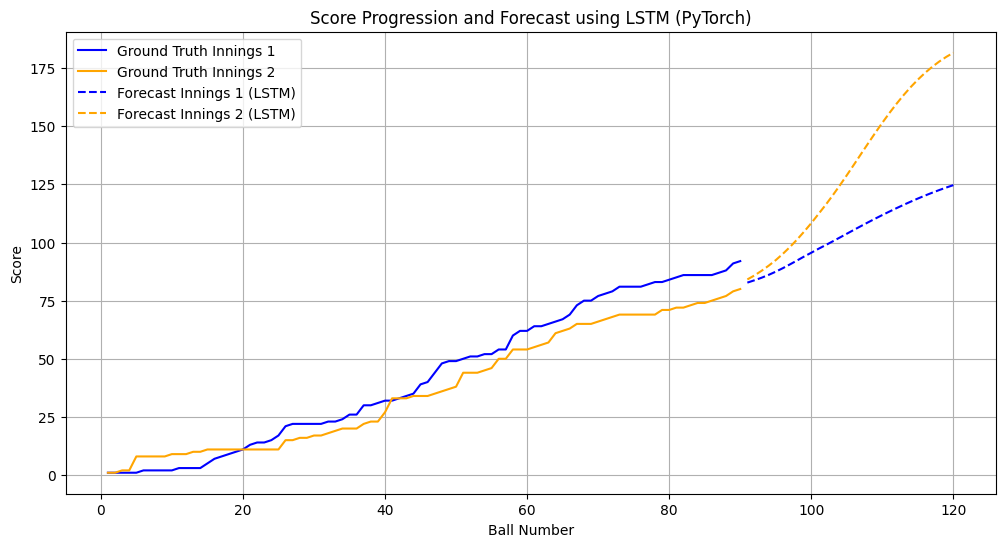

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

# Define 15 overs (90 balls)
overs_limit = 90

# Prepare training data
train_y_innings1 = innings1.to_pandas()["curr_score"][:overs_limit].values
train_y_innings2 = innings2.to_pandas()["curr_score"][:overs_limit].values

# Forecast for additional 5 overs (30 balls)
forecast_horizon = 30

# Scale data for LSTM
scaler = MinMaxScaler()
train_y_innings1_scaled = scaler.fit_transform(train_y_innings1.reshape(-1, 1))
train_y_innings2_scaled = scaler.fit_transform(train_y_innings2.reshape(-1, 1))

# Function to create sequences for LSTM
def create_sequences(data, sequence_length=10):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

sequence_length = 10
X_innings1, y_innings1 = create_sequences(train_y_innings1_scaled, sequence_length)
X_innings2, y_innings2 = create_sequences(train_y_innings2_scaled, sequence_length)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Get the last output
        return out

# Initialize models
model_innings1 = LSTMModel()
model_innings2 = LSTMModel()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer_innings1 = torch.optim.Adam(model_innings1.parameters(), lr=0.001)
optimizer_innings2 = torch.optim.Adam(model_innings2.parameters(), lr=0.001)

# Training function
def train_model(model, X, y, optimizer, epochs=100):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X)  # Input dimension is already suitable for LSTM
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

# Train both models
train_model(model_innings1, X_innings1, y_innings1, optimizer_innings1)
train_model(model_innings2, X_innings2, y_innings2, optimizer_innings2)

# Forecasting function
def forecast_lstm(model, data, steps, sequence_length):
    model.eval()
    predictions = []
    input_seq = torch.tensor(data[-sequence_length:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
    with torch.no_grad():
        for _ in range(steps):
            next_value = model(input_seq).item()
            predictions.append(next_value)
            input_seq = torch.cat((input_seq[:, 1:, :], torch.tensor([[[next_value]]])), dim=1)
    return np.array(predictions)

# Forecast for innings 1 and 2
forecast_y_innings1 = forecast_lstm(model_innings1, train_y_innings1_scaled.flatten(), forecast_horizon, sequence_length)
forecast_y_innings2 = forecast_lstm(model_innings2, train_y_innings2_scaled.flatten(), forecast_horizon, sequence_length)

# Inverse scale the forecasted values
forecast_y_innings1 = scaler.inverse_transform(forecast_y_innings1.reshape(-1, 1)).flatten()
forecast_y_innings2 = scaler.inverse_transform(forecast_y_innings2.reshape(-1, 1)).flatten()

# Generate x-axis for forecast
forecast_x = np.arange(overs_limit + 1, overs_limit + forecast_horizon + 1)

# Plot actual and forecasted values
fig, ax = plt.subplots(figsize=(12, 6))

# Ground truth for first 15 overs
ax.plot(np.arange(1, overs_limit + 1), train_y_innings1, label="Ground Truth Innings 1", linestyle="-", color="blue")
ax.plot(np.arange(1, overs_limit + 1), train_y_innings2, label="Ground Truth Innings 2", linestyle="-", color="orange")

# Forecasted values
ax.plot(forecast_x, forecast_y_innings1, label="Forecast Innings 1 (LSTM)", linestyle="--", color="blue")
ax.plot(forecast_x, forecast_y_innings2, label="Forecast Innings 2 (LSTM)", linestyle="--", color="orange")

# Plot settings
ax.set_title("Score Progression and Forecast using LSTM (PyTorch)")
ax.set_xlabel("Ball Number")
ax.set_ylabel("Score")
ax.legend()
ax.grid(True)

plt.show()

In [38]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

# Final score of Innings 1
final_score_innings1 = innings1.to_pandas()["curr_score"].values[-1]

# Prepare training data for Innings 2
train_y_innings2 = innings2.to_pandas()["curr_score"].values
overs_limit = 90  # Use first 15 overs (90 balls) for training

# Scale the data
scaler = MinMaxScaler()
train_y_innings2_scaled = scaler.fit_transform(train_y_innings2.reshape(-1, 1))

# Sequence preparation for LSTM
def create_sequences(data, sequence_length=10):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

sequence_length = 10
X_innings2, y_innings2 = create_sequences(train_y_innings2_scaled, sequence_length)

# LSTM Model for Score Forecasting
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Get the last output
        return out

# Initialize model, loss function, and optimizer
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_innings2)
    loss = criterion(outputs, y_innings2)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Forecast the final score for Innings 2
def forecast_final_score(model, data, steps, sequence_length):
    model.eval()
    input_seq = torch.tensor(data[-sequence_length:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
    with torch.no_grad():
        for _ in range(steps):
            next_value = model(input_seq).item()
            input_seq = torch.cat((input_seq[:, 1:, :], torch.tensor([[[next_value]]])), dim=1)
    return next_value

# Forecast remaining balls
forecast_horizon = len(train_y_innings2) - overs_limit
final_score_innings2 = forecast_final_score(model, train_y_innings2_scaled.flatten(), forecast_horizon, sequence_length)

# Inverse transform the forecasted score
final_score_innings2 = scaler.inverse_transform([[final_score_innings2]])[0, 0]

# Decision: Will Innings 2 cross Innings 1?
if final_score_innings2 > final_score_innings1:
    print(f"Innings 2 will likely surpass Innings 1's score. Final Score: {final_score_innings2:.2f}")
else:
    print(f"Innings 2 will likely not surpass Innings 1's score. Final Score: {final_score_innings2:.2f}")

Epoch 0, Loss: 0.5043158531188965
Epoch 10, Loss: 0.3523879647254944
Epoch 20, Loss: 0.19708764553070068
Epoch 30, Loss: 0.04933714494109154
Epoch 40, Loss: 0.041717298328876495
Epoch 50, Loss: 0.03653759881854057
Epoch 60, Loss: 0.024066491052508354
Epoch 70, Loss: 0.01439957320690155
Epoch 80, Loss: 0.007214795332401991
Epoch 90, Loss: 0.0031118281185626984
Innings 2 will likely surpass Innings 1's score. Final Score: 201.63


In [39]:
innings2

innings,ball,runs,wickets,curr_score,curr_wickets,overs,run_rate,required_run_rate,target
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
2.0,0.1,1.0,0.0,1.0,0.0,0.0,0.0,6.65,134.0
2.0,0.2,0.0,0.0,1.0,0.0,0.0,0.0,6.65,134.0
2.0,0.3,1.0,0.0,2.0,0.0,0.0,0.0,6.6,134.0
2.0,0.4,0.0,0.0,2.0,0.0,0.0,0.0,6.6,134.0
2.0,0.5,6.0,0.0,8.0,0.0,0.0,0.0,6.3,134.0
…,…,…,…,…,…,…,…,…,…
2.0,19.299999,0.0,0.0,113.0,4.0,19.0,5.947369,21.0,134.0
2.0,19.4,3.0,0.0,116.0,4.0,19.0,6.105263,18.0,134.0
2.0,19.5,1.0,0.0,117.0,4.0,19.0,6.157895,17.0,134.0
